# 02-Missing Values
Con el objetivo de mejorar nuestro modelo vamos a intentar incorporar mas features.<br>
El problema es que nos vamos a econtrar con `features` que tienen datos faltantes (missing values) con los que vamos a tener que tomar decisiones sobre como seguir

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Cargamos los DataSets

In [2]:
X_full = pd.read_csv('train.csv', index_col='Id')
X_test_full = pd.read_csv('test.csv', index_col='Id')

#nota: esta bueno que utilicemos el 'ID' porque de esa manera podemos estar seguros de a que casa corresponde cada dato

In [3]:
X_full.shape

(1460, 80)

In [4]:
# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

In [5]:
# por el momento solo nos vamos a quedar con las columnas que tienen variables numericas
# mas adelante vamos a codificar las variables categoricas para poder incluirlas en el modelo.
print(f'BEFORE selection X_full.shape:{X_full.shape}')
X = X_full.select_dtypes(exclude = ['object'])
print(f'AFTER selection X.shape: {X.shape}')

# -------------------------------------------

print(f'BEFORE selection X_test_full.shape:{X_test_full.shape}')
X_test = X_test_full.select_dtypes(exclude = ['object'])
print(f'AFTER selection X_test.shape: {X_test.shape}')

BEFORE selection X_full.shape:(1460, 79)
AFTER selection X.shape: (1460, 36)
BEFORE selection X_test_full.shape:(1459, 79)
AFTER selection X_test.shape: (1459, 36)


Nos quedamos solo con 36 de las 79 columnas que tenia el dataset originalmente

In [6]:
from sklearn.model_selection import train_test_split
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [7]:
X_train.shape, y_train.shape

((1168, 36), (1168,))

In [8]:
X_valid.shape, y_valid.shape

((292, 36), (292,))

In [9]:
# cuantos datos faltantes hay entre los features de nuestros datos de entrenamiento
missing_val_count_by_column = X_train.isnull().sum()
print(missing_val_count_by_column[missing_val_count_by_column>0])

LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


In [10]:
cols_with_missing_val = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Una libreria muy util para visualizar datos faltantes es la libreria [`missingno`](https://joss.theoj.org/papers/10.21105/joss.00547)

<AxesSubplot:>

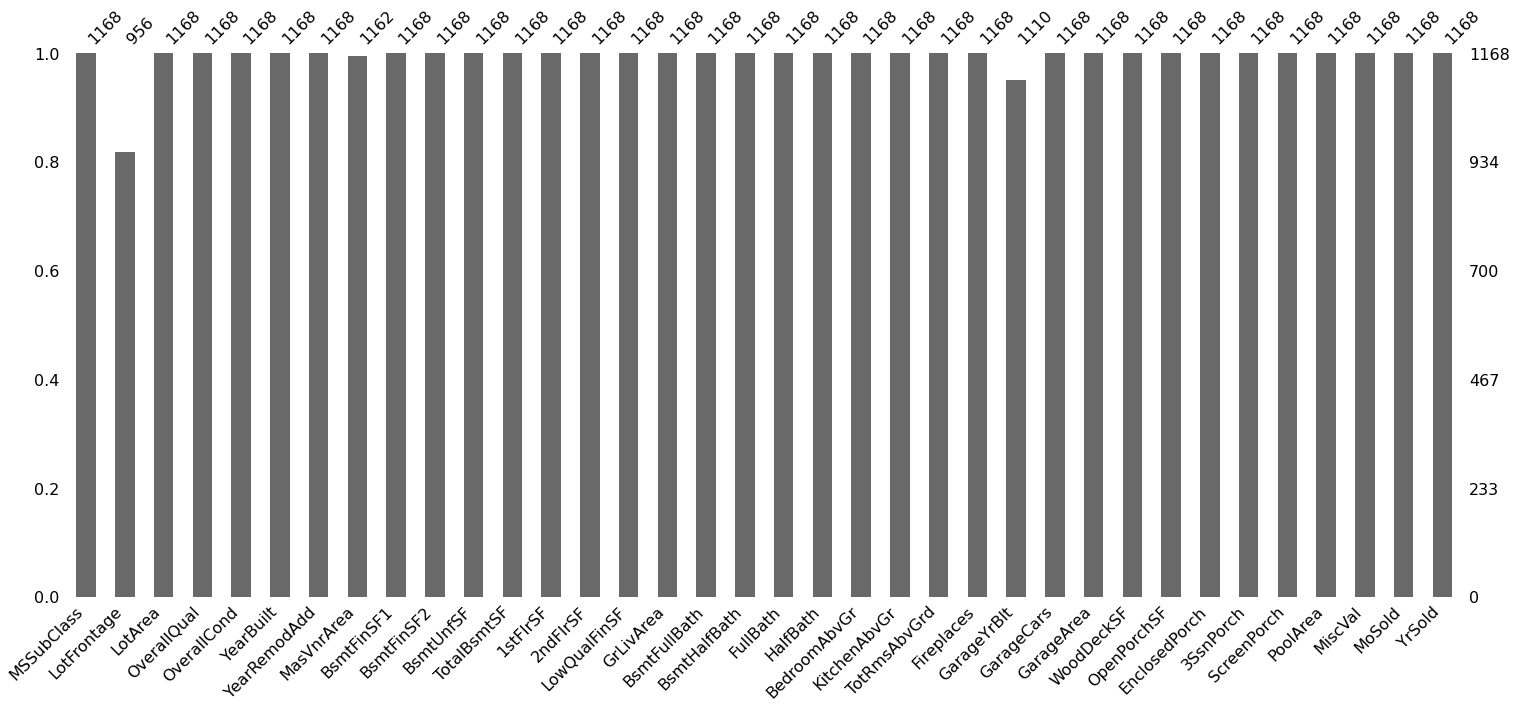

In [11]:
import missingno as msno
msno.bar(X_train)

<AxesSubplot:>

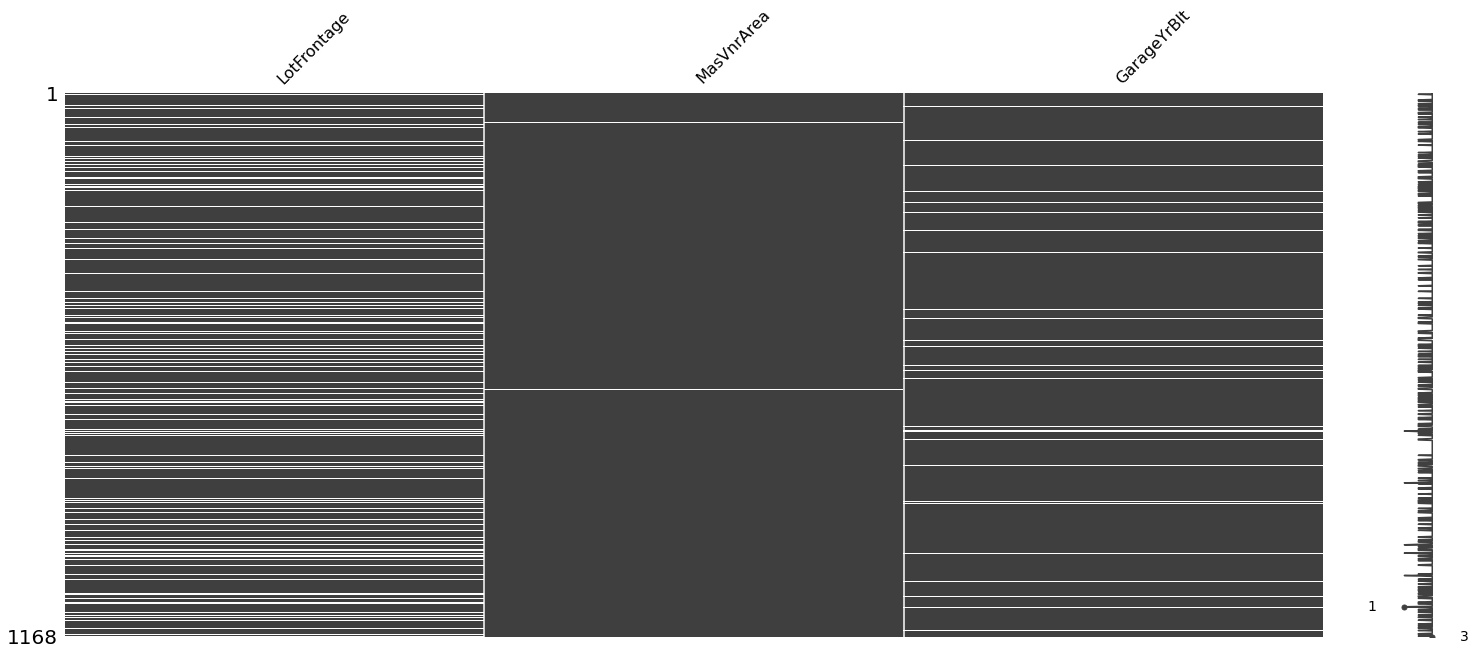

In [12]:
msno.matrix(X_train[cols_with_missing_val])

<AxesSubplot:>

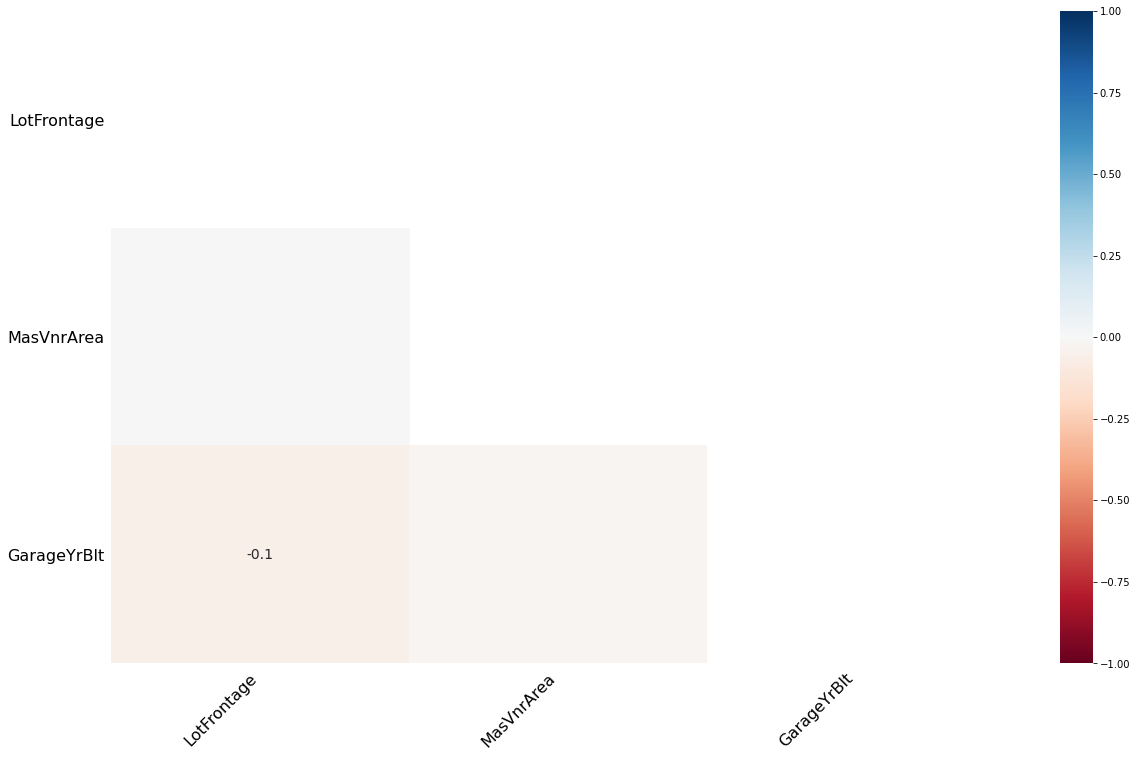

In [13]:
msno.heatmap(X_train)

Las ultimas dos figuras (msno.matrix y msno.heatmap) muestran que hay correlacion alguna entre los datos faltantes y que la ausencia de esos datos son evengos aleatorios

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# definimos una funcion para evaluar que estrategia de limpieza del dataset es mas adecuada
def score_dataset(X_train, X_valid, y_train, y_valid):
    # Definimos el modelo
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    
    # Entrenamos el modelo
    model.fit(X_train, y_train)
    
    # Prediccion
    predictions = model.predict(X_valid)
    
    return mean_absolute_error(y_valid, predictions)

### Estrategia 1. Eliminamos las features que tienen valores nulos
Notar que con esta estrategia estams perdiendo un monton de informacion importante. Pero vamos a seguir adelante para saber como nos va...


In [15]:
reduced_X_train = X_train.drop(cols_with_missing_val, axis = 1)
reduced_X_valid = X_valid.drop(cols_with_missing_val, axis = 1)
reduced_X_train.shape, reduced_X_valid.shape

((1168, 33), (292, 33))

In [16]:
print('-'*50, 'RESULTS','-'*50)
print('MAE (eliminando columnas con datos faltantes)')
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))
print('-'*50, 'RESULTS','-'*50)

-------------------------------------------------- RESULTS --------------------------------------------------
MAE (eliminando columnas con datos faltantes)
17837.82570776256
-------------------------------------------------- RESULTS --------------------------------------------------


### Estrategia 2. Imputacion de datos faltantes


In [17]:
from sklearn.impute import SimpleImputer

# Definimos el Imputador
my_imputer = SimpleImputer(strategy='mean') # no modificamos ningun parametro por lo tanto la estrategia que se define por defecto
                             # es 'mean'

# Entrenamos y aplicamos el Imputador
# ---- X_train ----
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_train.columns = X_train.columns

# ---- X_valid ----
imputed_X_valid = pd.DataFrame(my_imputer.fit_transform(X_valid))
imputed_X_valid.columns = X_valid.columns

In [18]:
imputed_X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20.0,90.000000,11694.0,9.0,5.0,2007.0,2007.0,452.0,48.0,0.0,...,774.0,0.0,108.0,0.0,0.0,260.0,0.0,0.0,7.0,2007.0
1,20.0,60.000000,6600.0,5.0,5.0,1962.0,1962.0,0.0,0.0,0.0,...,308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2009.0
2,30.0,80.000000,13360.0,5.0,7.0,1921.0,2006.0,0.0,713.0,0.0,...,432.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,8.0,2009.0
3,20.0,69.614017,13265.0,8.0,5.0,2002.0,2002.0,148.0,1218.0,0.0,...,857.0,150.0,59.0,0.0,0.0,0.0,0.0,0.0,7.0,2008.0
4,20.0,118.000000,13704.0,7.0,5.0,2001.0,2002.0,150.0,0.0,0.0,...,843.0,468.0,81.0,0.0,0.0,0.0,0.0,0.0,1.0,2006.0


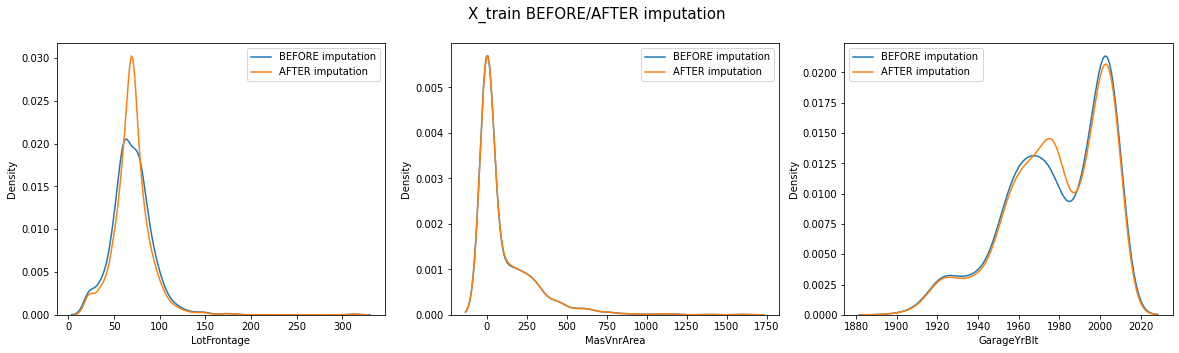

In [19]:
fig, axes = plt.subplots(nrows=1,
                         ncols=3,
                         figsize = (20,5))

sns.kdeplot(data = X_train, x = 'LotFrontage', ax = axes[0], label = 'BEFORE imputation')
sns.kdeplot(data = imputed_X_train, x = 'LotFrontage', ax = axes[0], label = 'AFTER imputation')
axes[0].legend()

sns.kdeplot(data = X_train, x = 'MasVnrArea', ax = axes[1], label = 'BEFORE imputation')
sns.kdeplot(data = imputed_X_train, x = 'MasVnrArea', ax = axes[1], label = 'AFTER imputation')
axes[1].legend()


sns.kdeplot(data = X_train, x = 'GarageYrBlt', ax = axes[2], label = 'BEFORE imputation')
sns.kdeplot(data = imputed_X_train, x = 'GarageYrBlt', ax = axes[2], label = 'AFTER imputation')
axes[2].legend()


plt.suptitle('X_train BEFORE/AFTER imputation', size = 15)
plt.show()

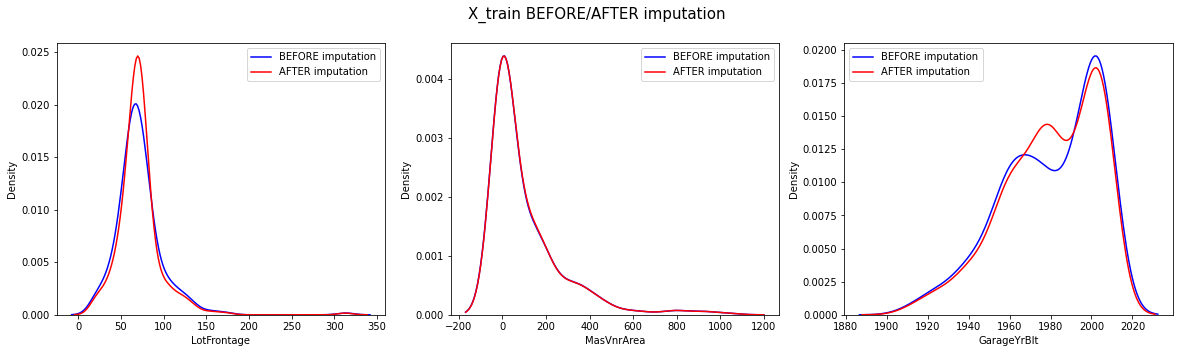

In [20]:
fig, axes = plt.subplots(nrows=1,
                         ncols=3,
                         figsize = (20,5))

sns.kdeplot(data = X_valid, x = 'LotFrontage', ax = axes[0], label = 'BEFORE imputation', color = 'blue')
sns.kdeplot(data = imputed_X_valid, x = 'LotFrontage', ax = axes[0], label = 'AFTER imputation', color = 'red')
axes[0].legend()

sns.kdeplot(data = X_valid, x = 'MasVnrArea', ax = axes[1], label = 'BEFORE imputation', color = 'blue')
sns.kdeplot(data = imputed_X_valid, x = 'MasVnrArea', ax = axes[1], label = 'AFTER imputation', color = 'red')
axes[1].legend()


sns.kdeplot(data = X_valid, x = 'GarageYrBlt', ax = axes[2], label = 'BEFORE imputation', color = 'blue')
sns.kdeplot(data = imputed_X_valid, x = 'GarageYrBlt', ax = axes[2], label = 'AFTER imputation', color = 'red')
axes[2].legend()


plt.suptitle('X_train BEFORE/AFTER imputation', size = 15)
plt.show()

<AxesSubplot:>

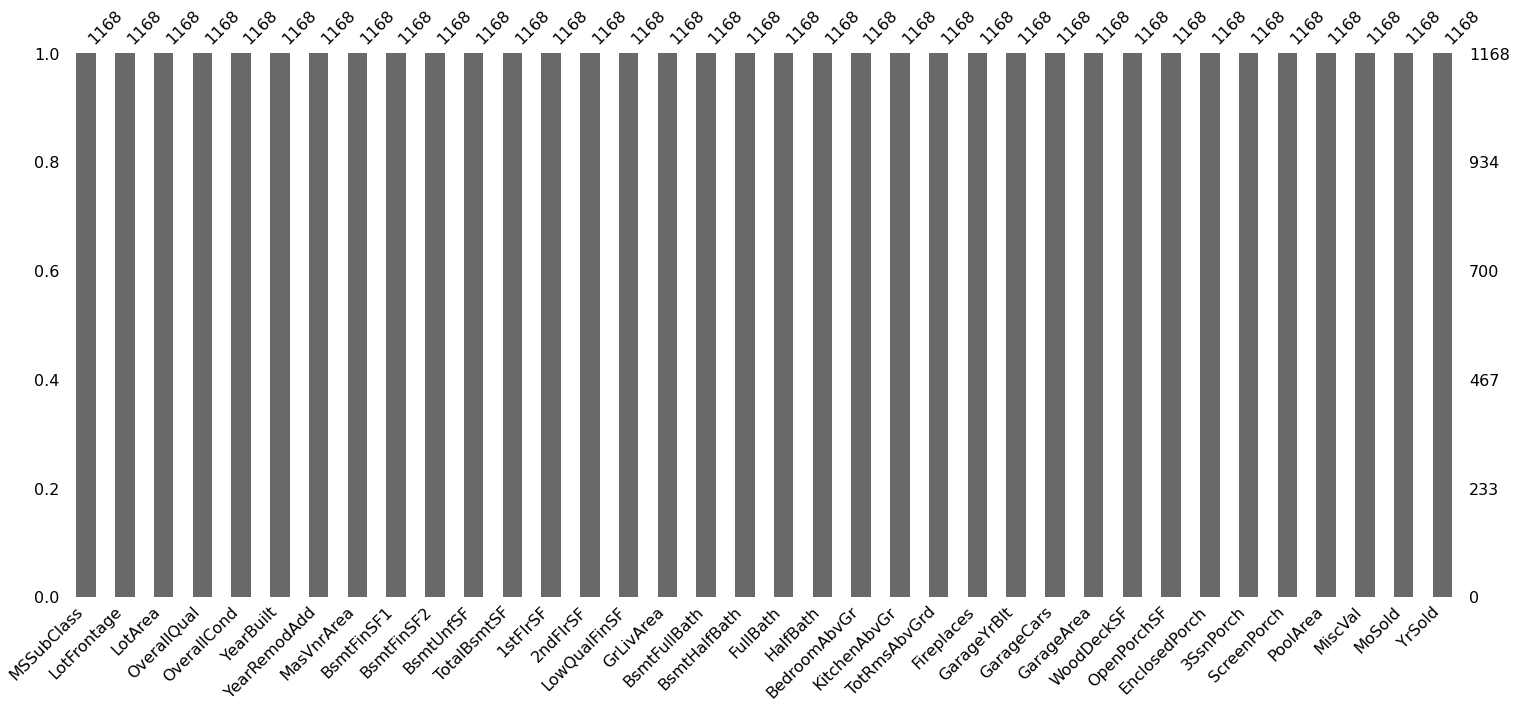

In [21]:
msno.bar(imputed_X_train)

<AxesSubplot:>

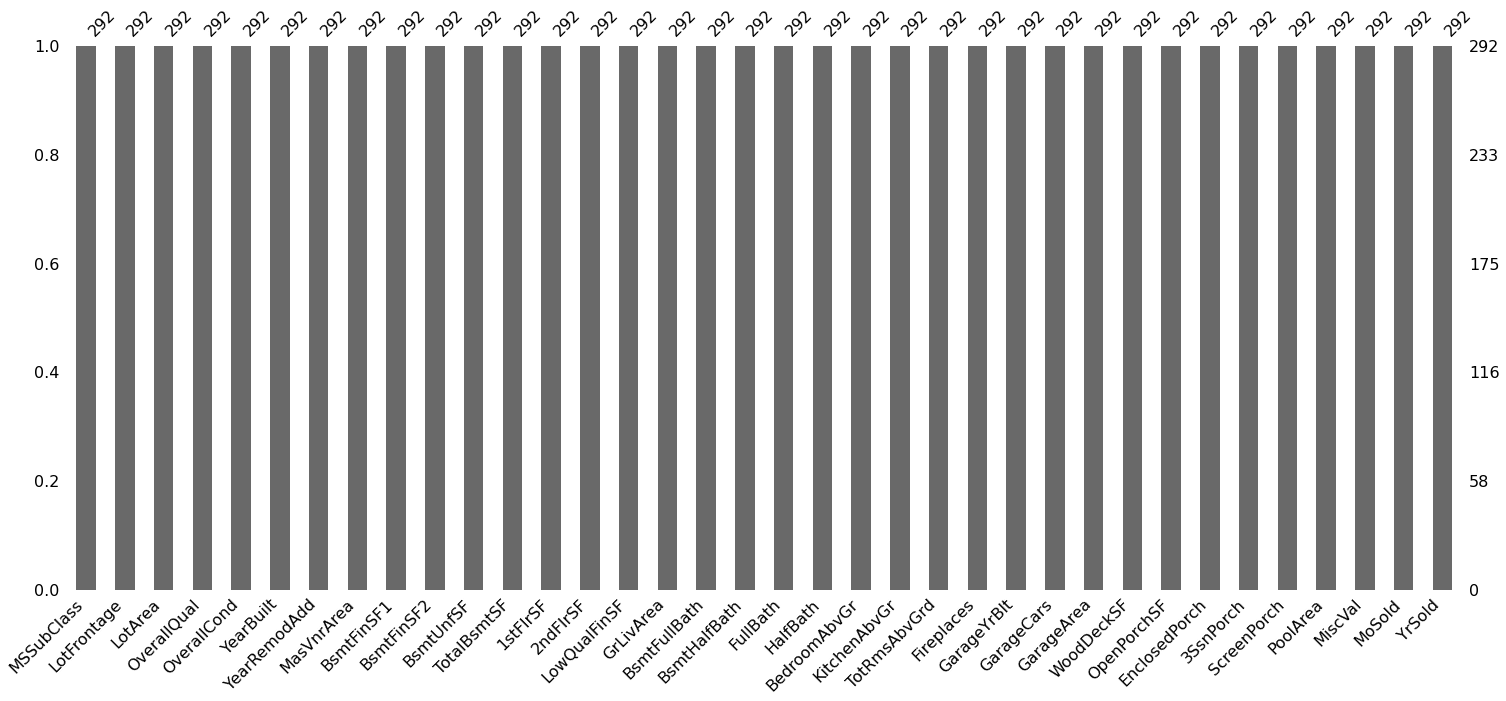

In [22]:
msno.bar(imputed_X_valid)

In [23]:
imputed_X_valid.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20.0,71.75102,32668.0,6.0,3.0,1957.0,1975.0,104.503448,1219.0,0.0,...,484.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,3.0,2007.0
1,50.0,79.00000,9490.0,6.0,7.0,1941.0,1950.0,0.000000,403.0,165.0,...,240.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,8.0,2006.0
2,50.0,71.75102,7015.0,5.0,4.0,1950.0,1950.0,161.000000,185.0,0.0,...,352.0,0.0,0.0,248.0,0.0,0.0,0.0,0.0,7.0,2009.0
3,60.0,83.00000,10005.0,7.0,5.0,1977.0,1977.0,299.000000,392.0,0.0,...,505.0,288.0,117.0,0.0,0.0,0.0,0.0,0.0,3.0,2008.0
4,160.0,21.00000,1680.0,6.0,5.0,1971.0,1971.0,381.000000,0.0,0.0,...,264.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0


In [24]:
print('-'*50, 'RESULTS','-'*50)
print("MAE (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))
print('-'*50, 'RESULTS','-'*50)

-------------------------------------------------- RESULTS --------------------------------------------------
MAE (Imputation):
18056.85163242009
-------------------------------------------------- RESULTS --------------------------------------------------


**Resultado:** En este caso particular, dio  mejores resultados la eliminacion de las columnas que tenian datos faltantes que la imputacion usando `SimpleImputer(strategy='mean')`. Esto no es lo mas comun, pero es lo que dio para este caso particular. Tal vez huiera fncionado mejor si hubieramos utilizado otro metodo de imputacion

# Parte 3. Predicciones

In [25]:
final_X_train = imputed_X_train
final_X_valid = imputed_X_valid

In [26]:
# Definimos el modelo
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Entrenamos el modelo
model.fit(final_X_train, y_train)

RandomForestRegressor(random_state=0)

In [35]:
# Get validation predictions and MAE
preds_valid = model.predict(final_X_valid)
print('-'*50, 'RESULTS','-'*50)
print("MAE (Final Result):")
print(mean_absolute_error(y_valid, preds_valid))
print('-'*50, 'RESULTS','-'*50)

-------------------------------------------------- RESULTS --------------------------------------------------
MAE (Final Result):
18056.85163242009
-------------------------------------------------- RESULTS --------------------------------------------------


In [28]:
X_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,730.0,140,0,0,0,120,0,0,6,2010
1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,312.0,393,36,0,0,0,0,12500,6,2010
1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,482.0,212,34,0,0,0,0,0,3,2010
1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,470.0,360,36,0,0,0,0,0,6,2010
1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,506.0,0,82,0,0,144,0,0,1,2010


In [29]:
# cuantos datos faltantes hay entre los features del dado para test (X_test, que viene de X_test_full)
missing_val_count_by_column = X_test.isnull().sum()
print(missing_val_count_by_column[missing_val_count_by_column>0])

LotFrontage     227
MasVnrArea       15
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt      78
GarageCars        1
GarageArea        1
dtype: int64


In [30]:
final_X_imputer = SimpleImputer()
final_X_test = pd.DataFrame(final_X_imputer.fit_transform(X_test))
final_X_test.columns = X_test.columns
final_X_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,144.0,...,730.0,140.0,0.0,0.0,0.0,120.0,0.0,0.0,6.0,2010.0
1,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,0.0,...,312.0,393.0,36.0,0.0,0.0,0.0,0.0,12500.0,6.0,2010.0
2,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,0.0,...,482.0,212.0,34.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0
3,60.0,78.0,9978.0,6.0,6.0,1998.0,1998.0,20.0,602.0,0.0,...,470.0,360.0,36.0,0.0,0.0,0.0,0.0,0.0,6.0,2010.0
4,120.0,43.0,5005.0,8.0,5.0,1992.0,1992.0,0.0,263.0,0.0,...,506.0,0.0,82.0,0.0,0.0,144.0,0.0,0.0,1.0,2010.0


In [31]:
# cuantos datos faltantes hay entre los features del dado para test (X_test, que viene de X_test_full)
missing_val_count_by_column = final_X_test.isnull().sum()
print(missing_val_count_by_column[missing_val_count_by_column>0])

Series([], dtype: int64)


In [32]:
# Hacemos la prediccion
predictions = model.predict(final_X_test)

In [33]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': predictions})
output.to_csv('submission-02-missing-values.csv', index=False)

In [34]:
output.head()

,Id,SalePrice
0,1461,125245.50
1,1462,155237.00
2,1463,180755.22
3,1464,184071.50
4,1465,197144.40
